# Document classification : tutorial

This practical session is dedicated to NLP basic tools that will enable us to handle textual data through the **Bag-of-Words (BoW)** paradigm.


## A. Processing chain design
**Main steps:**
1. Data reading \& importation
    - The corpus can be loaded in RAM (otherwise, you should use a *data loader* to bufferise the importation)
    - Encoding is a big problem: you have to make sure that the data are correctly read.
2. Data pre-processing, transformation \& filtering
    - remove *useless* information: figures, ponctuations, capitals, *etc*... **usefulness depends on applications! [obviously]**
    - Segment into words (=*Tokenization*)
    - Elimination of stop-words
    - Stemming/lemmatization (rootization)
    - Byte-pair encoding to find compound words (e.g. Sorbonne University, City of Paris, Prime Minister, etc...)
3. Digital data processing (Bag-of-Words)
    - Normalization *term-frequency* / binarization
    - Inverse document frequency* normalization
    - Elimination of rare words, too frequent words
    - Construction of separability criteria to eliminate words etc...
4. Learning a classifier
    - Choice of the type of classifier
    - Adjustment of the parameters of the classifier (regularization, balancing, etc...)

## B. Exploitation of the processing chain

This step is called the realization of a campaign of experiments: it is the key point that we want to work on in NLP this year.
1. It is impossible to test all the combinations in relation to the above proposals... Therefore, we have to eliminate some of them.
    - By discussing with the business experts
    - By doing preliminary tests
1. After this first filtering, we must:
    - Choose an evaluation that is reliable and not too slow (cross-validation, leave-one-out, split learning/single test)
    - Run large experiments
        - = *grid-search
        - parallelise on several machines
        - know how to run on a server and disconnect
1. Collect and analyze results


## C. Inference & industrialization

The inference is then very classical: the optimal processing chain is able to process new documents



In [17]:
import numpy as np
import matplotlib.pyplot as plt


# A-2: reprocessing & string manipulations 

1. Understand the examples
1. Build a chain where each action can be activated/disactivated

If you are not familia with regex, take a look at: https://docs.python.org/3/howto/regex.html

**Regex** is probably the most important tool to custom your processing chain!

In [18]:
doc = 'Le chat est devant la maison, 9 rue du zoo. Le chien attend à l\'intérieur.\nSon site web préféré est www.spa.fr '
print(doc)

Le chat est devant la maison, 9 rue du zoo. Le chien attend à l'intérieur.
Son site web préféré est www.spa.fr 


In [19]:
import re

# replace url by a keywork URL
doc = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', doc)  # note: this regex is far from perfect
print(doc)
# you can add some special token into the document (thus add token into the dictionary)

# suppress numbers
doc = re.sub('[0-9]+', '', doc) # remplacer une séquence de chiffres par rien
print(doc)

Le chat est devant la maison, 9 rue du zoo. Le chien attend à l'intérieur.
Son site web préféré est URL 
Le chat est devant la maison,  rue du zoo. Le chien attend à l'intérieur.
Son site web préféré est URL 


In [43]:
# retrieving (and suppressing) ponctuation
import string

punc = string.punctuation  
print(punc)
punc += '\n\r\t'
#print(punc)
doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))  
print(doc)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
le chat est devant la maison   rue du zoo  le chien attend a l interieur  son site web prefere est url 


In [21]:
# suppress accent and all non normalized char
import unicodedata

doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
doc = doc.lower()
print(doc )

le chat est devant la maison   rue du zoo  le chien attend a l interieur  son site web prefere est url 


# A-3: Bag od Words Model 
## Tokenization (=String split) & dictionary 

Let's tokenize !

**WARNING** : we use a standard syntax to understand the process... Later, we are going to use advanced build-in functions.

In [22]:
# word list
words = doc.split() # optional args to choose the splitting chars

# counting
from collections import Counter

dico = Counter(words)
print(dico)

Counter({'le': 2, 'est': 2, 'chat': 1, 'devant': 1, 'la': 1, 'maison': 1, 'rue': 1, 'du': 1, 'zoo': 1, 'chien': 1, 'attend': 1, 'a': 1, 'l': 1, 'interieur': 1, 'son': 1, 'site': 1, 'web': 1, 'prefere': 1, 'url': 1})


In [23]:
# dictionary = mapping function : word => index of the word in the dictionary

trans = dict(zip(list(dico.keys()), np.arange(len(dico)).tolist()))
print(trans)

# test
print('index of word chat:',trans['chat'])

{'le': 0, 'chat': 1, 'est': 2, 'devant': 3, 'la': 4, 'maison': 5, 'rue': 6, 'du': 7, 'zoo': 8, 'chien': 9, 'attend': 10, 'a': 11, 'l': 12, 'interieur': 13, 'son': 14, 'site': 15, 'web': 16, 'prefere': 17, 'url': 18}
index of word chat: 1


In [24]:
# Building the vector associated to the sentence

d = np.zeros(len(trans))
for m in words:
    d[trans[m]] += 1
    
print(d)


[2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
# switching to a sparse matrix to save some space
from scipy.sparse import coo_matrix

ds = coo_matrix(d)

print(ds)   # obviously, the current vector is full of data
            # in the future with real data, vectors will be full of 0!

  (0, 0)	2.0
  (0, 1)	1.0
  (0, 2)	2.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0


# Advanced framwork to compute bag of words 

The function ```sklearn.feature_extraction.text.CountVectorizer``` can perform all previous steps... And much more through (many) optional arguments

1. Documentation <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html"> link </a>
    - test on toy data
    - check your ability to exploit the dictionary 
        - retrieve the index of a word
        - retrieve the word corresponding to an index
    - check the filtering options (rare words etc)

1. Try to extract N-grams (bigram and trigram) (cf documentation)

1. it is critical to distinguish dictionary building and dictionary exploitation. (1) At the pre-processing step, we increase the vocabulary size and filter useless words... (2) The training step consists in finding the coefficients associated with each word. (3) In the inference step, the dictionary should be fixed (otherwise, the coefficients become meaningless).
    - split your dataset into two parts
    - constituer le dictionnaire sur les données d'apprentissage
    - appliquer sur les données de test et vérifier que les indices d'un même mot sont bien identiques entre l'apprentissage et le test.
    
**WARNING** do not confuse *fit_transform* = building + use with *transform* (use only, dictionary fixed). 

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [\
     'This is the first document.',\
     'This document is the second document.',\
     'And this is the third one.',\
     'Is this the first document?',\
 ]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus) # Output is a sparse matrix
print(vectorizer.get_feature_names())

print(X.toarray()) # Convert to numpy array

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


/home/charles/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())
print(X2.toarray())

['and this', 'document is', 'first document', 'is the', 'is this', 'second document', 'the first', 'the second', 'the third', 'third one', 'this document', 'this is', 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


# Tutorial on classifiers

scikit learn is object oriented: that means you will be able to switch easily from one classifer to another. 

In [28]:
import numpy as np
import sklearn.naive_bayes as nb
from sklearn import svm
from sklearn import linear_model as lin

# very basic data (once understood, use textual corpus instead)
N = 100
X = np.random.randn(N,2) 
X[:int(N/2), :] += 2
X[int(N/2):, :] -= 2
y = np.array([1]*int(N/2) + [-1]*int(N/2))

# Linear SVM 
clf = svm.LinearSVC()
# Naive Bayes
clf = nb.MultinomialNB()
# logistic regression
clf = lin.LogisticRegression()

# training
clf.fit(X, y)  
yhat = clf.predict([[2., 2.]]) # use on new data

print("prediction:",yhat)
print("classifier:",clf.coef_) # retrieve the coefs from inside the object (cf doc)

prediction: [1]
classifier: [[1.43136991 1.45882087]]


In [29]:
# Solution 1 to evaluate: cross validation

from sklearn.model_selection import cross_val_score

# everything is inside :)
# possible to parallelize with n_jobs
scores = cross_val_score( clf, X, y, cv=5)

print(scores)

[1. 1. 1. 1. 1.]


In [30]:
# Solution 2: only one split between train/test
from sklearn.model_selection import train_test_split

# with a seed to enhence reproducibility
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0) 
clf.fit(X_train, y_train)

# Application 
yhat = clf.predict(X_test)
print(yhat)


[ 1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1 -1
  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]


In [31]:
# Solution 3: explicit cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))
    X_train = X[train]
    y_train = y[train]
    X_test  = X[test]
    y_test  = y[test]
    # training
    # evaluation


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


# let's move on real data

Here, to explore this classical NLP pipeline, we propose to do binary sentiment classification.  For this, we use a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 

- [The original dataset can be found here](http://ai.stanford.edu/~amaas/data/sentiment/)

To make things easier, the data was already formatted into a json (`json_pol`) containing a train and a test list of `(string(review),int(class))` couples. As it's a binary classification problem, there are two classes: 

- `0` codes for negative reviews 
- `1` codes for positive reviews


The json has the following format: 
```json
{
"train":[["this is a positive review",1],["this is a negative review",0],...],
"test":[["this is a positive review",1],["this is a negative review",0],...]
}
```


------------------------------------
# WARMUP (just read and run)
## Step 1: Load Data



### <font color='red'> /!\ YOU NEED TO UNZIP dataset/json_pol.zip first /!\ </font>

The json of the following format: `{"train":[[review,class],...], "test":[[review,class],...]}`. 

 - We need to load it and collect both test and train lists:

In [32]:
import json
from collections import Counter

#### /!\ YOU NEED TO UNZIP dataset/json_pol.zip first /!\


# Loading json
with open("./datasets/json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")



Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

## Step 2: Feature extraction

Now that we have the data, we need to vectorize the text so it can be used by classifiers.
Different methods exists to vectorize text. Here we use a [bag of word](https://en.wikipedia.org/wiki/Bag-of-words_model) approach:

>  In the bag of word model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

In other words, each text becomes a (sparse) vector which codes for its words. With the following function from scikit-learn, it is straightforward to get a bag of word from raw texts: [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

>Convert a collection of text documents to a matrix of token counts
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data. [USER GUIDE](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)



In [33]:
from sklearn.feature_extraction.text import CountVectorizer
classes = [pol for text,pol in train]
corpus = [text for text,pol in train]

# vectorizer = CountVectorizer(input='content', encoding='utf-8',
#                              decode_error='strict', strip_accents=None,
#                              lowercase=True, preprocessor=None, tokenizer=None,
#                              stop_words=None, token_pattern='(?u)\b\w\w+\b',
#                              ngram_range=(1, 1), analyzer='word',
#                              max_df=1.0, min_df=1, max_features=None,
#                              vocabulary=None, binary=False, dtype='numpy.int64')


vectorizer = CountVectorizer()

X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names()[:500]) # we only print a few

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m', '100min', '100mph', '100s', '100th', '100x', '100yards', '101', '101st', '102', '102nd', '103', '104', '1040', '1040a', '1040s', '105', '1050', '105lbs', '106', '106min', '107', '108', '109', '10am', '10lines', '10mil', '10min', '10minutes', '10p', '10pm', '10s', '10star', '10th', '10x', '10yr', '11', '110', '1100', '11001001', '1100ad', '111', '112', '1138', '114', '1146', '115', '116', '117', '11f', '11m', '11th', '12', '120', '1200', '1200f', '1201', '1202', '123', '12383499143743701', '125', '125m', '127', '128', '12a', '12hr', '12m', '12mm', '12s', '12th', '13', '130', '1300', '1300s', '131', 

/home/charles/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
print(X.shape)
print(vectorizer.get_feature_names()[70000:70500])

(25000, 93860)


/home/charles/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NotFittedError: Vocabulary not fitted or provided

## Step 3: Classifiers

Once we have vectorized data, we can use them to train statistical classifiers.

Here, we propose to use three classic options:

- Naïve bayes
- Logistic Regression
- SVM


We fit each model below with default parameters

and we evaluate the accuracy of each model

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, classes)


#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=100,n_jobs=-1)
lr_clf.fit(X, classes)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X, classes)


true = [pol for text,pol in test]
test_corpus = [text for text,pol in test]
X_test = vectorizer.transform(test_corpus)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)


print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")

/home/charles/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/charles/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy: 0.81356
Logistic Regression accuracy: 0.86392
SVM accuracy: 0.84576


--------------------------------------------------

# EXERCISES (now it's your turn)

To further improve performances, we can try to improve the simple bag of word model as used above to address some issues **=> BoW variants:**
 
- **(a) Pre-prcessing, clean text:** punctuation, UPPER CASE, numbers... Do cleaning bring improvements?
- **(b) Dictionary processing**: stop words (existing/corpus-specific list), frequent vs infrequent words, max number of words- 
- **(c) Binary vectors**
- **(d) TF-IDF**
- **(e) N-grams**


**(a) Clean text ?**
- **strip_accents:** {‘ascii’, ‘unicode’, None}
Remove accents and perform other character normalization during the preprocessing step. ‘ascii’ is a fast method that only works on characters that have an direct ASCII mapping. ‘unicode’ is a slightly slower method that works on any characters. None (default) does nothing.
Both ‘ascii’ and ‘unicode’ use NFKD normalization from unicodedata.normalize.

- **lowercase:** boolean, True by default
Convert all characters to lowercase before tokenizing.

- **preprocessor:** callable or None (default)
Override the preprocessing (string transformation) stage while preserving the tokenizing and n-grams generation steps.

    - **token_pattern:** string. Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'. The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator).
    - **`Prepocessor`**: argument takes a function which processes text directly. This way it becomes easy to do "fancy" things like:
        - [part of speech tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging)
        - [stemming](https://en.wikipedia.org/wiki/Stemming) 
        - To do both, you can use [NLTK tagger](http://www.nltk.org/api/nltk.tag.html) and [NLTK stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem).

- **[Byte-pair encoding](https://www.freecodecamp.org/news/evolution-of-tokenization/)** to find compound words (e.g. Sorbonne University, City of Paris, Prime Minister, etc...)

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [36]:
import re
import 

reg = "\b[^\W]\b" #matches word with characters 

# 1) Try removing punctuation or putting text to lower case (maybe use a regex)
# 2) Try "Stemming" - "pos-tagging" the text

punc = string.punctuation  
punc += '\n\r\t'
def preprocess(text):
    """
    Transforms text to remove unwanted bits.
    """
    # Ponctuation
    text = text.translate(str.maketrans(punc, ' ' * len(punc))) 
    return text.lower() # This function is only taking care of dots, what about !:,?+-&*%

vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode') #preprocess=preprocess
X = vectorizer.fit_transform(corpus)

**(b) Dictionary processing**: If we visualize the word frequency distribution we see that a few words (roughly 20) appear a lot more than the others. These words are often refered to as **stop words**. Would remove them improve accuracy ?


[('the', 568723), ('a', 306953), ('and', 301892), ('of', 283618), ('to', 261847), ('is', 203049), ('in', 169976), ('I', 132488), ('that', 126813), ('this', 113720), ('it', 107895), ('/><br', 100974), ('was', 92656), ('as', 83127), ('with', 82563), ('for', 80915), ('The', 67290), ('but', 66261), ('on', 61192), ('movie', 60756)]


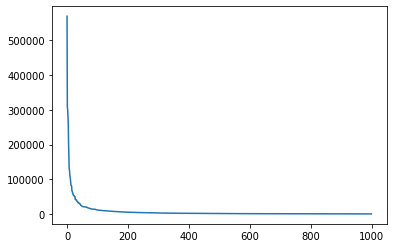

In [50]:
# Let's plot the count of the 1000 most used words:

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

wc = Counter()
for text,pol in train+test:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(1000)]

plt.plot(freq[:1000])
print(wc.most_common(20))

**Let's remove stopwords:** english stop words: direclty on sklearn 

- **stop_words:** string {‘english’}, list, or None (default)
    - If ‘english’, a built-in stop word list for English is used. There are several known issues with ‘english’ and you should consider an alternative (see Using stop words).
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'.
    - If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [38]:
vectorizer = CountVectorizer(stop_words='english') 

**Build your own list**

In [53]:
# CountVectorizer can take a list of stop words as argument.
# Build or download a list of stop word (from NLTK for exemple)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = ["the", "a", "and"] #Make a better list

vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(corpus)
X.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(25000, 74704)

**Stopwords from other languages**

In [57]:
len(stopwords.words('english'))

179

In [55]:
# French stop words: nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
#print(final_stopwords_list)
vectorizer = CountVectorizer(stop_words=final_stopwords_list)
#vectorizer = TfidfVectorizer(stop_words=final_stopwords_list)

**(b) Dictionary processing, restricting vocabulary size: corpus-specific stopwords** => max_df + suppress rare words (min_df) + max_features 

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

- **min_df:** float in range [0.0, 1.0] or int, default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

- **max_features:** int or None, default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
This parameter is ignored if vocabulary is not None.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [59]:
# max_df: float (ratio) / integer(number) of document above which we remove the word)
# min_df: float (ratio) / integer(number) of document under which we remove the word)

min_df=5             
max_df=0.5
max_features=10000
vectorizer = CountVectorizer(max_df=max_df,min_df=min_df,max_features=max_features) #try out some values
X = vectorizer.fit_transform(corpus)
#What is the dictionnary size now ?
dic_size = X.shape[1]###
print(dic_size)

10000


**(c) : Binary BoW**: instead of word counts, the bag of word vector can only represent used word.

- **binary:** boolean, default=False
If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

**(d) TF-IDF**: words can also be weighted by importance. $\text{Corpus : } C = \{\mathbf d_{1},\ldots,\mathbf d_{|C|}\}$, vocabulary $V = \{\mathbf w_{1},\ldots,\mathbf w_{|V|}\}$: 
- **$d_{ik}^{(tf)}$ term frequency** for word $w_k$ in document $d_i$, s.t. $\sum\limits_{k=1}^{|V|}d_{ik}^{(tf)}=1$
- **$\mathrm{df_{k}}$ document frequency** $\mathrm{df_{k}} =  \frac{|\{\mathbf d: t_{k} \in \mathbf d\}|}{|C|}$

$$ d_{ik}^{(tfidf)} = d_{ik}^{(tf)}   \log \frac{1}{\mathrm{df_{k}}} $$


## [TfidfVectorizer from scikit can be directly used](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer): experiment it!

**Main paramters:**
- **use_idf:** boolean, default=True. 
- **smooth_idf:** Smooth idf weights, default=True. Adds one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
- **sublinear_tf:** boolean, default=bool, default=False. Apply sublinear tf scaling, i.e. replace $d_{ik}^{(tf)}$ with $1 + log(d_{ik}^{(tf)})$.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True,          
smooth_idf=True      
sublinear_tf=False    

vectorizer = TfidfVectorizer(use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)
    

**(e) n-grams**: instead of words, consider n-uplets of words as tokens

- **ngram_range:** tuple (min_n, max_n)
The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

- **analyzer:** string, {‘word’, ‘char’, ‘char_wb’} or callable
Whether the feature should be made of word or character n-grams. Option ‘char_wb’ creates character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with space.
If a callable is passed it is used to extract the sequence of features out of the raw, unprocessed input.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [ ]:
ngram_range = (1,2) # unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=ngram_range,analyzer='word') # Maybe 2-grams or 3-grams bring improvements ?
X = vectorizer.fit_transform(corpus)
#What is the dictionnary size now ?
dic_size = X.shape[1]###
print(dic_size)

# Answer the following questions

- What is the most effective pre-processing ?
- Which model is the most accurate ?

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, classes)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X, classes)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X, classes)


true = [pol for text,pol in test]
test_corpus = [text for text,pol in test]
X_test = vectorizer.transform(test_corpus)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)


print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")

# Improving classifier performances
- **Using regularization** if the number of training sample is small wrt BoW size
- **Using relancing** if the number examples across class is inbalanced

# Visualizing features

It can be interesting to find out which words are the most positive or negative for our models. To do so, you can simply look how each models weigth each features with respect to each class.

In [ ]:
# we first build a dictionnary {id_feature : word} from our vectorizer

features = {v:k for k,v in vectorizer.vocabulary_.items()} # invert mapping (k2v)

### Naïve Bayes

For the naïve bayes model, we can look directly at `p(word | class)`

[MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

- **feature_log_prob_**: array, shape (n_classes, n_features). Empirical log probability of features given a class, P(x_i|y).

In [ ]:
import numpy as np
#Naïve bayes

k = 50 # we want the 50 most negative and positive words

feat_neg = nb_clf.feature_log_prob_[0] # get list of negative class log probability
#feat_pos =  # same for positive

most_neg = [] # find the corresponding words
most_pos = [] 

print(most_neg[:k])
print(most_pos[:k])

## Linear Models : Logistic Regression & SVM


For linear models, we can look at feature coefficients:
 [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 
 	
- **coef_:** array, shape (1, n_features) or (n_classes, n_features). Coefficient of the features in the decision function. coef_ is of shape (1, n_features) when the given problem is binary. In particular, when multi_class=’multinomial’, coef_ corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False).

In [ ]:
#Logistic Regression
k = 50 # we want the 50 most negative and positive words
feat = lr_clf.coef_[0] 


In [ ]:
#SVM
k = 50 # we want the 50 most negative and positive words
feat = svm_clf.coef_[0]



------------------------
## **(bonus:)**  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`


In [ ]:
# import ...

# Get text:
#text = "this is exemple text"

# Generate a word cloud image
# wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
